In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection, global_goal=None, local_goal=None, grid_goal=None):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        self.global_goal = global_goal
        self.local_goal = local_goal
        self.grid_goal = grid_goal
        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim (this is just for visualization of waypoints)
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()
        
    def local_to_grid(self, north_offset, east_offset):
        ng, eg, ag = self.local_goal
        self.grid_goal = grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
    
    def global_to_grid(self, north_offset, east_offset):
        self.local_goal = global_to_local(self.goal, global_home=self.global_nome)
        self.grid_goal = elf.local_to_grid(north_offset, east_offset)
    
    def move_goal_in_grid(self, grid_shape):
        grid_goal = self.grid_goal
        if grid_goal[0] > grid_shape[0] - 2:
            grid_goal = (grid_shape[0] - 2, grid_goal[1])
        elif grid_goal[0] < 1:
            grid_goal = (1, grid_goal[1])            
        if grid_goal[1] > grid_shape[1] - 2:
            grid_goal = (grid_goal[0], grid_shape[1] - 2)
        elif grid_goal[1] < 1:
            grid_goal = (grid_goal[0], 1)  
        self.grid_goal = grid_goal

In [8]:
def main(global_goal=None, local_goal=None, grid_goal=None):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=60)
    drone = MotionPlanning(conn,
                           global_goal=global_goal,
                           local_goal=local_goal,
                           grid_goal=grid_goal)
    time.sleep(1)

    drone.start()

In [9]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        #pp = np.array(parr)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [10]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path):
    pruned_path = [p for p in path]
    # TODO: prune the path!
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-1.22397450e+02  3.77924793e+01  1.07000000e-01], local position [-0.07733755 -0.00661004 -0.10746705]
North offset = -316, east offset = -445
global home [-122.39745   37.79248    0.     ], position [-1.22397450e+02  3.77924793e+01  1.07000000e-01], local position [-0.07733755 -0.00661004 -0.10746705]
gs:  (316, 445)
Goal is set to (488, 182) with the parameter
Grid Start and Goal:  (316, 445) (488, 182)


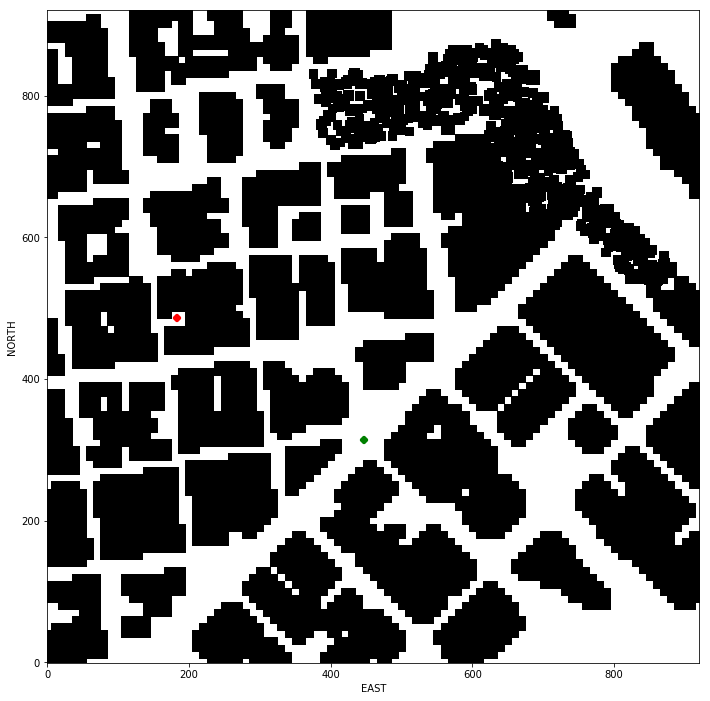

Found a path.
Path length: 399  cost: 429.5233764908631
Pruned Path length:  9


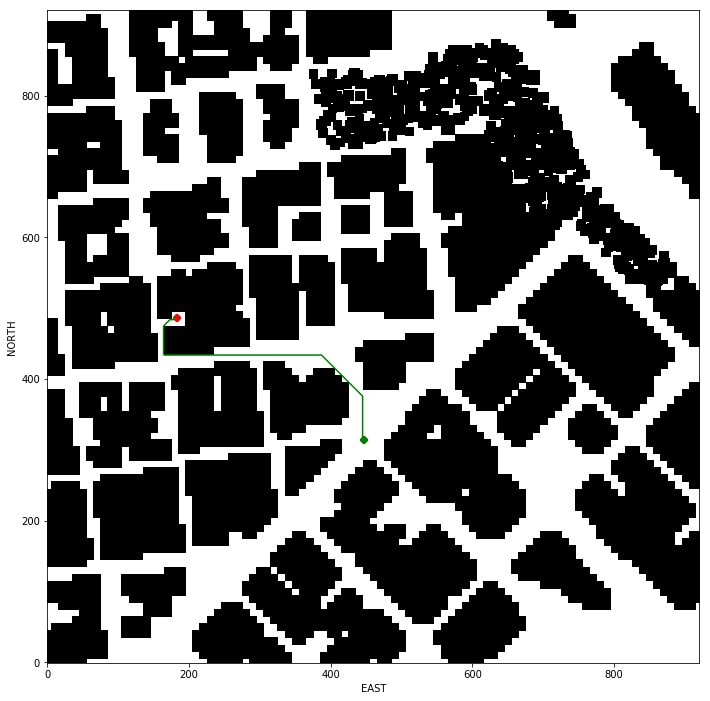

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [60, 0, 5, 0]
waypoint transition
target position [118, -58, 5, 0]
waypoint transition
target position [118, -280, 5, 0]
waypoint transition
target position [119, -281, 5, 0]
waypoint transition
target position [159, -281, 5, 0]
waypoint transition
target position [168, -272, 5, 0]
waypoint transition
target position [168, -267, 5, 0]
waypoint transition
target position [171, -264, 5, 0]
landing transition
disarm transition
manual transition
Closing connection ...


In [11]:
def plan_path(self):
    self.flight_state = States.PLANNING
    print("Searching for a path ...")
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 5

    self.target_position[2] = TARGET_ALTITUDE

    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    grid_shape = grid.shape
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    # TODO: read lat0, lon0 from colliders into floating point values
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])      
    #grid_start = (-north_offset, -east_offset)
    # TODO: convert start position to current position rather than map center
    # TODO: set home position to (lon0, lat0, 0)
    self.set_home_position(lat0, lon0, 0)

    # TODO: retrieve current global position
    # TODO: convert to current local position using global_to_local()
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    north, east, att = local_pos
    print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                     self.local_position))
    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("gs: ",grid_start)

    if self.global_goal is not None:
        self.global_to_grid(north_offset, east_offset )
    elif self.local_goal is not None:
        self.local_to_grid(north_offset, east_offset )
    elif self.grid_goal is not None:
        self.grid_goal
        
    
    goal_list = []
    
    # If goal location is in an obstacle
    goal_obs = True
    if self.grid_goal is not None:
        self.move_goal_in_grid(grid_shape)
        grid_goal = self.grid_goal
            
        print("Goal is set to {0} with the parameter".format(grid_goal))
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        if goal_obs:
            goal_list.append(grid_goal)
        
    # randomly select a goal
    dist_idx = 100.0
    goal_try = 0
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_position[0] + change[0] / dist_idx,
                self.global_position[1] + change[1] / (dist_idx),
                self.global_position[2] + change[2] * 10.0)
        print("Goal Global: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("Goal Local: ", local_goal)
        ng, eg, ag = local_goal
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        
        if grid_goal[0] > grid_shape[0] - 2:
            grid_goal = (grid_shape[0] - 2, grid_goal[1])
        elif grid_goal[0] < 1:
            grid_goal = (1, grid_goal[1])            
        if grid_goal[1] > grid_shape[1] - 2:
            grid_goal = (grid_goal[0], grid_shape[1] - 2)
        elif grid_goal[1] < 1:
            grid_goal = (grid_goal[0], 1)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        if goal_obs:
            goal_list.append(grid_goal)
    
    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    print('Grid Start and Goal: ', grid_start, grid_goal)
    plot(grid, grid_start, grid_goal, goal_list=goal_list)
    path, cost = a_star(grid, heuristic, grid_start, grid_goal)
    print("Path length:", len(path)," cost:", cost)
    #plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!
    pruned_path = prune_path(path)
    print("Pruned Path length: ", len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    #print("A* path:")
    #for p in path:
    #    print(p)
        
    #print("Pruned_path:")
    #for p in pruned_path:
    #    print(p)

    # Convert path to waypoints
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    self.send_waypoints()
MotionPlanning.plan_path = plan_path
main(grid_goal = (488, 182))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.3974533   37.7924804    0.       ], position [-122.4004214   37.7940213    0.241    ], local position [ 1.71203491e+02 -2.63826599e+02 -2.41716415e-01]
North offset = -316, east offset = -445
global home [-122.3974533   37.7924804    0.       ], position [-122.4004214   37.7940213    0.241    ], local position [ 1.71203491e+02 -2.63826599e+02 -2.41716415e-01]
gs:  (485, 183)
change [-0.10695061  0.03536885  0.16375654]
Goal Global:  (-122.40149090606633, 37.79437498853521, 1.878565400494927)
Goal Local:  [ 207.92064345 -356.83819775   -1.8785654 ]
change [ 0.08551131  0.23634352 -0.12143336]
Goal Global:  (-122.39956628694593, 37.796384735172154, -0.9733336245636283)
Goal Local:  [ 431.98804629 -188.82083004    0.97333362]
change [ 0.24313565 -0.12241543  0.16641254]
Goal Global:  (-122.39799004347415, 37.79279714565462, 1.9051253976531601)
Goal Local:  [ 34.83840689 -47.

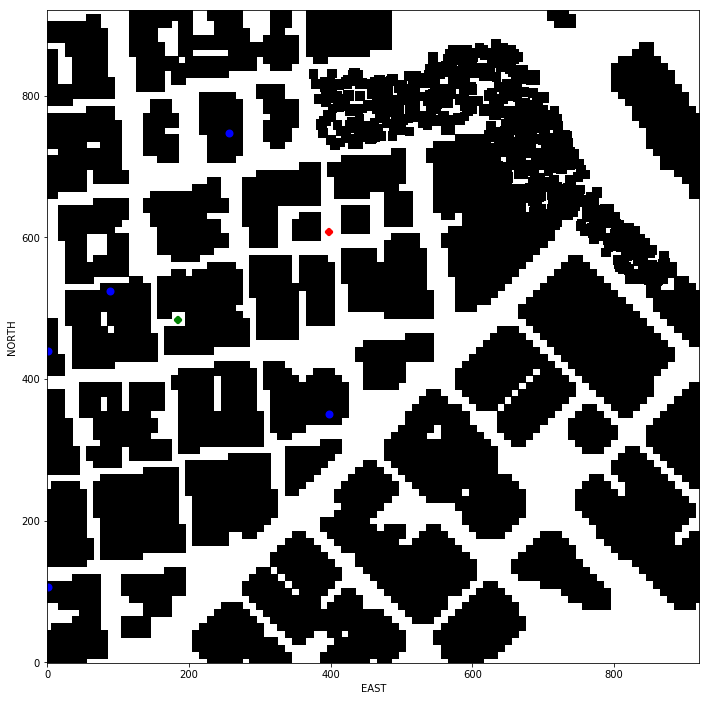

Found a path.
Path length: 335  cost: 361.8812408671323
Pruned Path length:  14


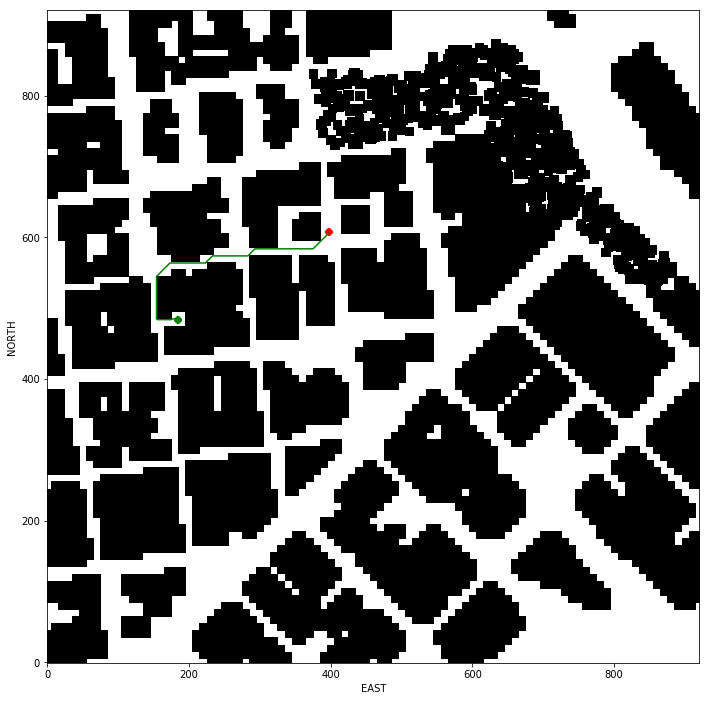

Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [169, -262, 5, 0]
waypoint transition
target position [169, -269, 5, 0]
waypoint transition
target position [168, -270, 5, 0]
waypoint transition
target position [168, -290, 5, 0]
waypoint transition
target position [169, -291, 5, 0]
waypoint transition
target position [229, -291, 5, 0]
waypoint transition
target position [248, -272, 5, 0]
waypoint transition
target position [248, -222, 5, 0]
waypoint transition
target position [258, -212, 5, 0]
waypoint transition
target position [258, -162, 5, 0]
waypoint transition
target position [268, -152, 5, 0]
waypoint transition
target position [268, -70, 5, 0]
waypoint transition
target position [289, -49, 5, 0]
waypoint transition
target position [292, -49, 5, 0]
landing transition
disarm transition
manual transition
Closing connection ...


In [12]:
main()